In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data=260
df=pd.read_csv("porosity.csv", header=None)
data_raw=np.array(df, dtype=float)
val_data=data_raw[train_data:310,:]
data=data_raw[0:train_data, :]
np.random.shuffle(data)
#min_max_scaler = preprocessing.MinMaxScaler()
#StandardScaler = preprocessing.StandardScaler()
#data = StandardScaler.fit_transform(data_raw)



In [3]:

s=30  #sampling size
seed_size=20 #size of seed data
q=5 #query size
n=int((train_data-seed_size)/s) # number of iteration needed to go through all samples

In [4]:
#Defining seed data
seed_data=data[0:seed_size,:]
new_data=pd.DataFrame(seed_data)
k=seed_data.shape[0]

In [5]:
#GP model for random sampling
def gp_eval(X, y):
    # Instantiate a Gaussian Process model
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    kernel = 1.0 * Matern(length_scale=0.1, nu=1.5)
    gp_eval = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp_eval.fit(X, y)
    r2_score=gp.score(X,y)
    print("GP model fit score is=",r2_score)
    #RMSE Error evaluation
    y_val_pred=gp_eval.predict(val_data[:, 0:4])
    tt=np.sqrt(np.mean((val_data[:, 4]-y_val_pred)**2))
    print("Random sampling RMSE value is =",tt)
    
    return tt

In [6]:
    X=data[:, 0:4]
    y=data[:,4]
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)
    r2_score=gp.score(X,y)
    print("GP model fit score is=",r2_score)
    y_val_pred=gp.predict(val_data[:, 0:4])
    rmse_cal=np.sqrt(np.mean((val_data[:, 4]-y_val_pred)**2))
    mse_cal=np.mean((val_data[:, 4]-y_val_pred)**2)
    print("Final rmse value is =",rmse_cal)

GP model fit score is= 0.9999999999999936
Final rmse value is = 0.027612566193510858


In [7]:
mse=[]
mse_random=[]
rmse=[]
rmse_random= []
for i in range(n):
    X=new_data.iloc[:, 0:4]
    y=new_data.iloc[:,4]
    # Instantiate a Gaussian Process model
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)
    r2_score=gp.score(X,y)
    print("GP model fit score is=",r2_score)
    #Evaluate current model against the validation set
    #RMSE Error evaluation
    y_val_pred=gp.predict(val_data[:, 0:4])
    rmse_cal=np.sqrt(np.mean((val_data[:, 4]-y_val_pred)**2))
    mse_cal=np.mean((val_data[:, 4]-y_val_pred)**2)
    print("Final rmse value is =",rmse_cal)
    rmse.append(rmse_cal)
    mse.append(mse_cal)
    #pool-based sampling from unlabeled pool
    XX=data[k+i*s:k+(i+1)*s, 0:4]   #taking the next few samples to predict variance
    y_pred,sigma =gp.predict(XX, return_std=True)  #predict variance
    sigma
    #Finding maximum variance of the new samples,Rank them and select top 5
    var_pred=pd.DataFrame(sigma, columns=["sigma"])
    new_input=pd.DataFrame(data[k+i*s:k+(i+1)*s,0:5])
    md=pd.concat([new_input, var_pred], axis=1)
    sorted_data=md.sort_values(by=['sigma'], ascending=False)
    #select top 5
    c_data=sorted_data.iloc[0:q,:]
    #concat the ne
    df_1=pd.DataFrame(new_data)
    new_data=pd.concat([df_1, c_data], axis=0)
    vv=new_data.shape[0]
    print(vv)

GP model fit score is= 0.9999999999999966
Final rmse value is = 0.06115811944667481
25
GP model fit score is= 0.9999999999999948
Final rmse value is = 0.045050264315125974
30
GP model fit score is= 0.999999999999989
Final rmse value is = 0.045088579474934616
35
GP model fit score is= 0.9999999999999878
Final rmse value is = 0.044943532244223296
40
GP model fit score is= 0.999999999999984
Final rmse value is = 0.04308282862147611
45
GP model fit score is= 0.9999999999999798
Final rmse value is = 0.042242196079765815
50
GP model fit score is= 0.9999999999999851
Final rmse value is = 0.04125189080877205
55
GP model fit score is= 0.9999999999999944
Final rmse value is = 0.04210342449159698
60


In [8]:
#random learning from the original pool
rmse_rand_orig= []
mse_rand_orig= []
for i in range(n):
        df_seed=pd.DataFrame(data[0:seed_size,:])
        if i==0:
            rand_rmse=gp_eval(df_seed.iloc[0:seed_size, 0:4], df_seed.iloc[0:seed_size, 4])
        else:
            df_unlabel=pd.DataFrame(data[seed_size:train_data,:])
            #df_unlabel=df.iloc[20:400,0:2]
            df_add=df_unlabel.sample(n=q*i)
            data_random=pd.concat([df_seed, df_add], axis=0)
            rand_rmse=gp_eval(data_random.iloc[:, 0:4], data_random.iloc[:, 4])
            ll=data_random.shape[0]
            print(ll)
            print(i)

        rmse_rand_orig.append(rand_rmse)
print(rmse_rand_orig)

GP model fit score is= 0.9999999999999933
Random sampling RMSE value is = 0.06115811922342472
GP model fit score is= 0.9989007350712513
Random sampling RMSE value is = 0.06106316934997535
25
1
GP model fit score is= 0.9902472894216373
Random sampling RMSE value is = 0.045843908748621605
30
2
GP model fit score is= 0.9858151767624223
Random sampling RMSE value is = 0.04804492022345085
35
3
GP model fit score is= 0.8698282452248701
Random sampling RMSE value is = 0.03397532545783154
40
4
GP model fit score is= 0.8387564952935426
Random sampling RMSE value is = 0.03574457433981628
45
5
GP model fit score is= 0.9662155726715
Random sampling RMSE value is = 0.042403895764164035
50
6
GP model fit score is= 0.6926848516924539
Random sampling RMSE value is = 0.03424337294420752
55
7
[0.06115811922342472, 0.06106316934997535, 0.045843908748621605, 0.04804492022345085, 0.03397532545783154, 0.03574457433981628, 0.042403895764164035, 0.03424337294420752]


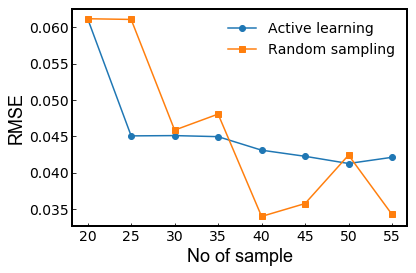

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
m=np.array(list(range(seed_size,seed_size+q*n, q)))
plt.plot(m,rmse, marker='o', label = "Active learning")
#plt.plot(m,mse_random, marker='s', label = "Random Sampling_2")
plt.plot(m,rmse_rand_orig, marker='s', label = "Random sampling")

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)  # change width
# naming the x axis
plt.xlabel('No of sample',fontname="Arial", fontsize=18)
plt.tick_params(direction='in', labelsize='medium')
plt.xticks(fontsize=14)
# naming the y axis
plt.ylabel('RMSE',fontname="Arial", fontsize=18)
plt.yticks(fontsize=14)
# function to show the plot
plt.legend()
plt.legend(frameon=False,fontsize=14)
plt.show()


In [ ]:
all_rmse=gp_eval(data[:, 0:4], data[:, 4])


In [59]:
#save model
import pickle

# save
with open('model_20_5_30.pkl','wb') as f:
    pickle.dump(gp,f)

# load
#with open('model.pkl', 'rb') as f:
#    gp2 = pickle.load(f)

#gp2.predict(val_data[:, 0:3])

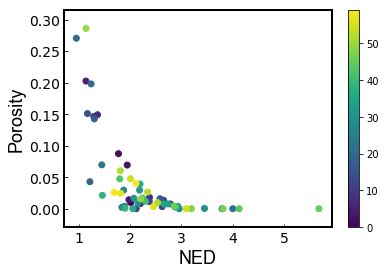

In [58]:
P=new_data[0]*220
V=new_data[1]
H=new_data[2]*1e-3
L=new_data[3]*1e-3
eta_m=0.527
rho=3920
cp=830
T_l=1923
T_0=308
k=34.6
r0=50e-6
alpha=k/rho/cp
bot=(rho*cp*(T_l-T_0))
NED=(eta_m*P)/(V*H*L)/bot
phi=new_data[4]
NED
t = np.arange(len(NED))
fig, ax = plt.subplots()
# naming the x axis
plt.xlabel('NED',fontname="Arial", fontsize=18)
plt.tick_params(direction='in', labelsize='small')
plt.xticks(fontsize=14)
# naming the y axis
plt.ylabel('Porosity',fontname="Arial", fontsize=18)
plt.yticks(fontsize=14)     # To change the y-axis
# The spines
plt.setp(ax.spines.values(), linewidth=2)
plt.scatter(NED, phi, c=t,cmap='viridis')
plt.colorbar()
plt.show()

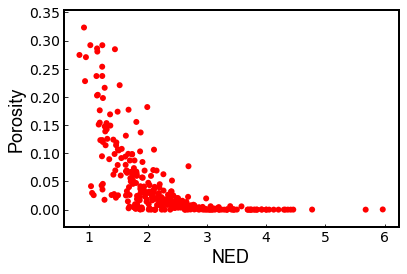

In [47]:
P=data_raw[:,0]*220
V=data_raw[:,1]
H=data_raw[:,2]*1e-3
L=data_raw[:,3]*1e-3
eta_m=0.527
rho=3920
cp=830
T_l=1923
T_0=308
k=34.6
r0=50e-6
alpha=k/rho/cp
bot=(rho*cp*(T_l-T_0))
NED=(eta_m*P)/(V*H*L)/bot
phi=data_raw[:,4]
NED
t = np.arange(len(NED))
fig, ax = plt.subplots()
# naming the x axis
plt.xlabel('NED',fontname="Arial", fontsize=18)
plt.tick_params(direction='in', labelsize='small')
plt.xticks(fontsize=14)
# naming the y axis
plt.ylabel('Porosity',fontname="Arial", fontsize=18)
plt.yticks(fontsize=14)     # To change the y-axis
# The spines
plt.setp(ax.spines.values(), linewidth=2)
plt.scatter(NED, phi,color='red', edgecolors="none")
#plt.colorbar()
plt.show()